In [28]:
from __future__ import print_function

import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

import argparse
import math
import os
import shutil
import time
import random
from functools import partial

from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import _LRScheduler

# from attacker import NoOpAttacker, PGDAttacker
# import net_cifar
# import net
from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
from utils.fastaug.fastaug import FastAugmentation
from utils.fastaug.augmentations import Lighting
from utils.misc import show_image_row
from utils.label_maps import CLASS_DICT
from models.stem_helper import *

In [29]:
# resume = "/ws/external/checkpoints/cifar10/resnet50_cos_e100_lr0.1_2/model_best.pth.tar"
resume = False
load = "/ws/external/checkpoints/cifar10/resnet50_cos_e100_lr0.1_2/model_best.pth.tar"
gpu_id = "0"
num_classes = 10
mixbn = False
mixstem = False
lr_schedule = "cos"
nesterov = True
# attack option
attack_iter = 0
attack_mode = 'pgd'
attack_epsilon = 1
attack_step_size  = 1.0
dct_ratio_low = 0.0
dct_ratio_high = 1.0
evaluate = False
checkpoint = "/ws/external/checkpoints"
data = "/ws/data/cifar10"
fastaug = False
train_batch = 8
test_batch = 8
workers = 4
arch = "resnet50"
make_adv = False
momentum = 0.9
lr = 0.1
weight_decay = 1e-4
smoothing = 0
IMAGE_SCALE = 2.0/255

In [30]:
# Use CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
use_cuda = torch.cuda.is_available()
# Random seed
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if use_cuda:
    torch.cuda.manual_seed_all(manualSeed)
best_acc = 0  # best test accuracy


In [31]:
def to_status(m, status):
    if hasattr(m, 'batch_type'):
        m.batch_type = status


to_clean_status = partial(to_status, status='clean')
to_adv_status = partial(to_status, status='adv')
to_mix_status = partial(to_status, status='mix')

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [32]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, stem=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if stem is None:
            stem = ResStemCifar
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        # self.stem = stem(3, self.inplanes, norm_layer)
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)



class AdvResNet(ResNet):
    '''
    The modified model using ResNet in torchvision.models.resnet.
    Usually we using DataParallel to wrap this model,
    so you'd better set the attacker and mixbn before using DataParallel.
    '''
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, stem=None, attacker=NoOpAttacker(), dct_ratio_low=0.0, dct_ratio_high=1.0, make_adv=False,
                 attack_mode='pgd'):
        super().__init__(block, layers, num_classes=num_classes, zero_init_residual=zero_init_residual,
                 groups=groups, width_per_group=width_per_group, replace_stride_with_dilation=replace_stride_with_dilation,
                 norm_layer=norm_layer, stem=stem)
        self.attacker = attacker
        self.mixbn = False
        self.attack_mode = attack_mode
        self.dct_ratio_low = dct_ratio_low
        self.dct_ratio_high = dct_ratio_high
        self.make_adv = make_adv

    def set_attacker(self, attacker):
        self.attacker = attacker

    def set_mixbn(self, mixbn):
        self.mixbn = mixbn


    def forward(self, x, labels):
        training = self.training
        input_len = len(x)
        # only during training do we need to attack, and cat the clean and auxiliary pics
        if training:
            self.eval()
            self.apply(to_adv_status)
            if isinstance(self.attacker, NoOpAttacker):
                images = x
                targets = labels
            else:
                # aux_images, _ = self.attacker.attack(x, labels, self._forward_impl, False, self.attack_mode)
                aux_images, _ = self.attacker.attack(x, labels, self, False, self.attack_mode)
                images = torch.cat([x, aux_images], dim=0)
                targets = torch.cat([labels, labels], dim=0)
            self.train()
            if self.mixbn:
                # the DataParallel usually cat the outputs along the first dimension simply,
                # so if we don't change the dimensions, the outputs will be something like
                # [clean_batches_gpu1, adv_batches_gpu1, clean_batches_gpu2, adv_batches_gpu2...]
                # Then it will be hard to distinguish clean batches and adversarial batches.
                self.apply(to_mix_status)
                return self._forward_impl(images).view(2, input_len, -1).transpose(1, 0), targets.view(2, input_len).transpose(1, 0)
            else:
                self.apply(to_clean_status)
                return self._forward_impl(images), targets

        elif self.make_adv == True:
            self.eval()
            self.apply(to_adv_status)
            images = x
            aux_images, _ = self.attacker.dct_attack3(x, labels, self._forward_impl,
                                                      dct_ratio_low=self.dct_ratio_low,
                                                      dct_ratio_high=self.dct_ratio_high)
            return images, aux_images-images, aux_images, self._forward_impl(images), self._forward_impl(aux_images), labels
            # self.eval()
            # self.apply(to_adv_status)
            # if isinstance(self.attacker, NoOpAttacker):
            #     images = x
            #     targets = labels
            # else:
            #     self.training = True
            #     # aux_images, _ = self.attacker.attack(x, labels, self._forward_impl)
            #     aux_images, _ = self.attacker.dct_attack3(x, labels, self._forward_impl,
            #                                               dct_ratio_low=self.dct_ratio_low,
            #                                               dct_ratio_high=self.dct_ratio_high)
            #     images = torch.cat([x, aux_images], dim=0)
            #     targets = torch.cat([labels, labels], dim=0)
            #     self.training = False
            # return self._forward_impl(images), targets
        else:
            images = x
            targets = labels
            return self._forward_impl(images), targets



def _resnet(arch, block, layers, pretrained, progress, attack_mode, **kwargs):
    model = AdvResNet(block, layers, **kwargs)
    # if attack_mode == "gradcam_attention":
    #     target_layer = "module.layer4.2.conv3"
    #     GradCam(model, target_layer)

    if pretrained:
        raise ValueError('do not set pretrained as True, since we aim at training from scratch')
        # state_dict = load_state_dict_from_url(model_urls[arch],
        #                                       progress=progress)
        # model.load_state_dict(state_dict)
    return model

def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


In [33]:
class NoOpAttacker():
    
    def attack(self, image, label, model):
        return image, -torch.ones_like(label)

    def set_model(self, model):
        self.model = model


class PGDAttacker():
    def __init__(self, num_iter, epsilon, step_size, kernel_size=15, prob_start_from_clean=0.0, translation=False, num_classes=1000, device='cuda:0',
                 dct_ratio_low=0.0, dct_ratio_high=1.0):
        step_size = max(step_size, epsilon / num_iter)
        self.num_iter = num_iter
        self.epsilon = epsilon * IMAGE_SCALE
        self.step_size = step_size*IMAGE_SCALE
        self.prob_start_from_clean = prob_start_from_clean
        self.device = device
        self.translation = translation
        self.num_classes = num_classes
        self.dct_ratio_low = dct_ratio_low
        self.dct_ratio_high = dct_ratio_high
        # self.dg = SMNorm(3, 3, groups=3)
        # self.gblur = CustomBlurPool(3, 3, 5, )

        if translation:
            # this is equivalent to deepth wise convolution
            # details can be found in the docs of Conv2d.
            # "When groups == in_channels and out_channels == K * in_channels, where K is a positive integer, this operation is also termed in literature as depthwise convolution."
            self.conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=kernel_size, stride=(kernel_size-1)//2, bias=False, groups=3).to(self.device)
            self.gkernel = get_kernel(kernel_size, nsig=3, device=self.device).to(self.device)
            self.conv.weight = self.gkernel

    def _create_random_target(self, label):
        label_offset = torch.randint_like(label, low=0, high=self.num_classes)
        return (label + label_offset) % self.num_classes

    def attack(self, image_clean, label, model, original=False, mode='pgd'):
        if mode == 'pgd':
            return self.pgd_attack(image_clean, label, model.module._forward_impl, original=False)
        elif mode == "pgd_dct":
            return self.pgd_dct_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "attention":
            return self.attention_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "gradcam_attention":
            return self.gradcam_attention_attack(image_clean, label, model, original=False)
        elif mode == "dg":
            return self.dg_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "gblur":
            return self.gblur_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "common":
            return self.common_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "advbn":
            return self.advbn_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "gnoise":
            return self.gaussian_noise_attack(image_clean, label, mean=0.0, std=0.5)
        elif mode == "unoise":
            return self.uniform_noise_attack(image_clean, label)
        elif mode == "dummy" or "sm" or "sm-lf":
            return self.dummy_attack(image_clean, label)

    def set_model(self, model):
        self.model = model

    def pgd_attack(self, image_clean, label, model, original=False):
        """
        aux_images, _ = self.attacker.attack(x, labels, self._forward_impl)
        """
        if original:
            target_label = label    # untargeted
        else:
            target_label = self._create_random_target(label)    # targeted
        lower_bound = torch.clamp(image_clean - self.epsilon, min=-1., max=1.)
        upper_bound = torch.clamp(image_clean + self.epsilon, min=-1., max=1.)

        ori_images = image_clean.clone().detach()

        init_start = torch.empty_like(image_clean).uniform_(-self.epsilon, self.epsilon)
        
        start_from_noise_index = (torch.randn([])>self.prob_start_from_clean).float() 
        start_adv = image_clean + start_from_noise_index * init_start

        adv = start_adv
        for i in range(self.num_iter):
            adv.requires_grad = True
            logits = model(adv)
            losses = F.cross_entropy(logits, target_label)
            g = torch.autograd.grad(losses, adv, 
                                    retain_graph=False, create_graph=False)[0]
            if self.translation:
                g = self.conv(g)
            # Linf step
            if original:
                adv = adv + torch.sign(g) * self.step_size  # untargeted
            else:
                adv = adv - torch.sign(g) * self.step_size  # targeted
            # Linf project
            adv = torch.where(adv > lower_bound, adv, lower_bound).detach()
            adv = torch.where(adv < upper_bound, adv, upper_bound).detach()
        
        return adv, target_label


In [34]:
if attack_iter == 0:
    attacker = NoOpAttacker()
else:
    attacker = PGDAttacker(attack_iter, attack_epsilon, attack_step_size,
                           num_classes=num_classes,
                           prob_start_from_clean=0.2 if not evaluate else 0.0,
                           dct_ratio_low=dct_ratio_low,
                           dct_ratio_high=dct_ratio_high)

if not os.path.isdir(checkpoint):
    mkdir_p(checkpoint)

print('==> Preparing data..')

dataset_name = (data).split("/")[-1]
if dataset_name == "cifar10":
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    if fastaug:
        transform_train.transforms.insert(0, FastAugmentation())

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = datasets.CIFAR10(root='/ws/data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch, shuffle=True, num_workers=workers, pin_memory=True)
    val_dataset = datasets.CIFAR10(root='/ws/data', train=False, download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch, shuffle=False, num_workers=workers, pin_memory=True)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    # create model
    print("=> creating model '{}'".format(arch))
    if mixbn:
        norm_layer = MixBatchNorm2d
    else:
        norm_layer = None

    if mixstem == 'dct':
        stem = ResStemCifarDCT
    elif mixstem == 'sm':
        stem = ResStemCifarSM
    else:
        stem = ResStemCifar

#     model = net_cifar.__dict__[arch](num_classes=num_classes, norm_layer=norm_layer, stem=stem,
#                                           dct_ratio_low=dct_ratio_low, dct_ratio_high=dct_ratio_high,
#                                           make_adv=make_adv, attack_mode=attack_mode)
    model = resnet50(num_classes=num_classes, norm_layer=norm_layer, stem=stem,
                                          dct_ratio_low=dct_ratio_low, dct_ratio_high=dct_ratio_high,
                                          make_adv=make_adv, attack_mode=attack_mode)



==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
=> creating model 'resnet50'


In [35]:
model

AdvResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [36]:
if not os.path.isdir(checkpoint):
    mkdir_p(checkpoint)
    
model.set_attacker(attacker)
model.set_mixbn(mixbn)


model = torch.nn.DataParallel(model).cuda()

cudnn.benchmark = True
print('    Total params: %.2f M' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

# define loss function (criterion) and optimizer
if smoothing == 0:
    criterion = nn.CrossEntropyLoss(reduction='none').cuda()
# implement a cross_entropy with label smoothing.
# First, perform a log_softmax; then fill the selected classes with 1-smoothing
# At last, use kl_div, which means:
# KL(p||q) = -\int p(x)ln q(x) dx - (-\int p(x)ln p(x) dx)
# kl_div is different from Crossentropy with a const number (\int p(x) ln p(x))
else:
    criterion = partial(label_smoothing_cross_entropy, classes=num_classes, dim=-1)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay,
                      nesterov=nesterov)

    Total params: 23.52 M


In [37]:
# Resume
title = 'Cifar-' + arch
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isfile(resume), 'Error: no checkpoint directory found!'
    checkpoint = os.path.dirname(resume)
    checkpoint = torch.load(resume)
    best_acc = checkpoint['best_acc']
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = state['lr']
    logger = Logger(os.path.join(checkpoint, 'log.txt'), title=title, resume=True)
else:
    if load:
        checkpoint = torch.load(load)
        if mixbn:
            to_merge = {}
            for key in checkpoint['state_dict']:
                if 'bn' in key:
                    tmp = key.split("bn")
                    aux_key = tmp[0] + 'bn' + tmp[1][0] + '.aux_bn' + tmp[1][1:]
                    to_merge[aux_key] = checkpoint['state_dict'][key]
                elif 'downsample.1' in key:
                    tmp = key.split("downsample.1")
                    aux_key = tmp[0] + 'downsample.1.aux_bn' + tmp[1]
                    to_merge[aux_key] = checkpoint['state_dict'][key]
            checkpoint['state_dict'].update(to_merge)

        model.load_state_dict(checkpoint['state_dict'])
    # logger = Logger(os.path.join(checkpoint, 'log.txt'), title=title)
    # logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])

In [38]:
train_dataset = datasets.CIFAR10(root='/ws/data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch, shuffle=True, num_workers=workers, pin_memory=True)
val_dataset = datasets.CIFAR10(root='/ws/data', train=False, download=True, transform=transform_test)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=test_batch, shuffle=False, num_workers=workers, pin_memory=True)
_, (inputs, targets) = next(enumerate(val_loader))

Files already downloaded and verified
Files already downloaded and verified


In [39]:
if use_cuda:
    inputs, targets = inputs.cuda(), targets.cuda(non_blocking=True)
model.cuda()
outputs, targets = model(inputs, targets)
target_layer= 'module.layer4.2.conv3'  # 'layer4.2.conv3'


In [41]:
attack_epsilon=5

In [117]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer, attack_iter=1, attack_epsilon=1, attack_step_size=1):
        self.model = model
        self.target_layer = target_layer
        self.attack_iter = attack_iter
        self.attack_epsilon = attack_epsilon
        self.attack_step_size = attack_step_size
        self.model.eval()
        self.hook_layer()

    def hook_layer(self):
        def forward_hook(module, input, output):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = output

        def backward_hook(module, grad_in, grad_output):
            self.gradient = torch.squeeze(grad_output[0])

        # Hook the selected layer
        for n, m in self.model.named_modules():
            if n == str(self.target_layer):
                m.register_forward_hook(forward_hook)
                m.register_backward_hook(backward_hook)


    def generate_mul_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        # input image [1, 3, 224, 224]
        # cont_output [1, 256, 13, 13]
        
        adv = input_image
        B, C, H, W = input_image.size()
        lower_bound = torch.clamp(input_image - self.attack_epsilon, min=-1., max=1.)
        upper_bound = torch.clamp(input_image + self.attack_epsilon, min=-1., max=1.)
#         lower_bound = input_image - self.attack_epsilon
#         upper_bound = input_image + self.attack_epsilon
        
        for i in range(self.attack_iter):
        
            model_output, target_class = self.model(adv, target_class)
            if target_class is None:
                target_class = np.argmax(model_output.data.numpy())
            # Target for backprop
            one_hot_output = torch.zeros_like(model_output).cuda()
            one_hot_output = torch.nn.functional.one_hot(targets, num_classes=10)

            # Zero grads
            self.model.zero_grad()
            # Backward pass with specified target
            model_output.backward(gradient=one_hot_output, retain_graph=True)
            # Get hooked gradients
            guided_gradients = self.gradient
            # Get convolution outputs
            target = self.conv_output
            # Get weights from gradients
            weights = guided_gradients.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)# torch.mean(guided_gradients, dim=1, keepdim=True)
            # Create empty numpy array for cam
            cam = (target * weights).sum(dim=1, keepdim=True)

            resized_cam = torch.nn.functional.interpolate(cam, (H, W), mode='bicubic')
            resized_cam = self.standardize(resized_cam)
            resized_cam2 = self.normalize(resized_cam)
            attention_map = F.sigmoid(resized_cam)
            adv_attention_map = F.sigmoid(-resized_cam)

            adv = adv * adv_attention_map.repeat(1, 3, 1, 1)
            
            adv_orig = adv
            
            # Linf project
            adv = torch.where(adv > lower_bound, adv, lower_bound).detach()
            adv = torch.where(adv < upper_bound, adv, upper_bound).detach()
            
                            
        model_output, target_class = self.model(adv, target_class)
        model_pred = torch.argmax(model_output, dim=1)
        
        return resized_cam, attention_map, adv, adv_orig, model_pred
    

    
    def standardize(self, resized_cam):
        resized_cam_mean = resized_cam.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        resized_cam_std = resized_cam.std(dim=2, keepdim=True).std(dim=3, keepdim=True) * self.attack_epsilon
        resized_cam = (resized_cam - resized_cam_mean) / (resized_cam_std+1e-5)
        
        return resized_cam
    
    def normalize(self, resized_cam):
        
        resized_cam = (resized_cam - torch.min(resized_cam)) / (torch.max(resized_cam) - torch.min(resized_cam))
        
        return resized_cam
        
        
        

In [118]:
targets

tensor([3, 8, 8, 0, 6, 6, 1, 6], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


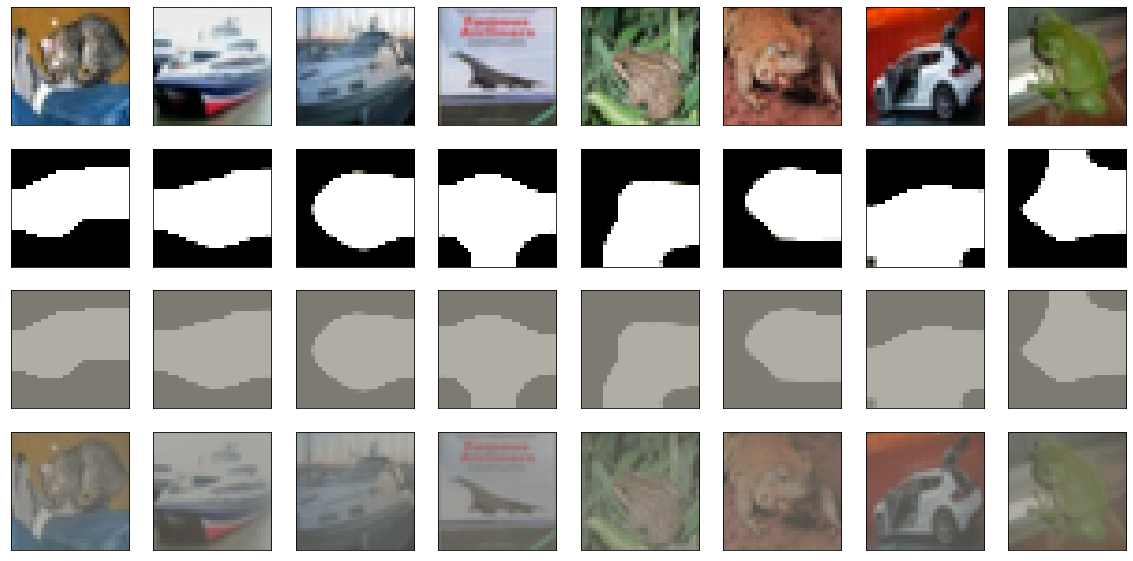

In [119]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=1, attack_epsilon=0.05, attack_step_size=1 )
# grad_cam.model
resized_cam, attention_map, adv, _, pred = grad_cam.generate_mul_cam(inputs, targets)
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu()])

In [110]:
pred

tensor([0, 8, 8, 9, 6, 3, 3, 3], device='cuda:0')

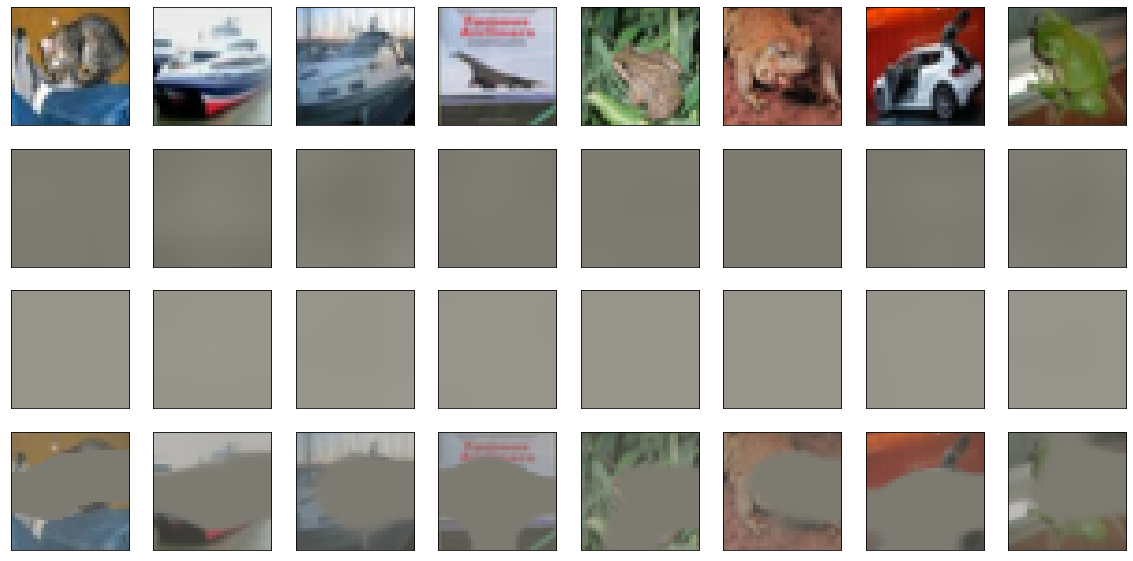

In [111]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=2, attack_epsilon=0.5, attack_step_size=1 )
# grad_cam.model
resized_cam, attention_map, adv, _, pred  = grad_cam.generate_mul_cam(inputs, targets)
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu()])

In [113]:
pred

tensor([3, 8, 8, 0, 3, 4, 3, 0], device='cuda:0')

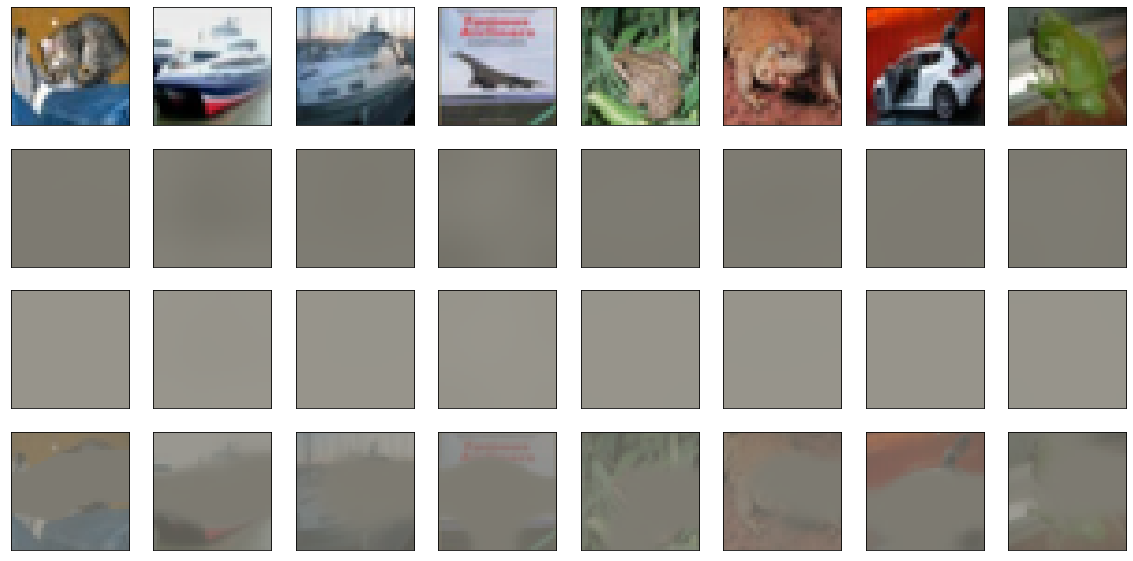

In [114]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=3, attack_epsilon=1, attack_step_size=1 )
# grad_cam.model
resized_cam, attention_map, adv, _, pred  = grad_cam.generate_mul_cam(inputs, targets)
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu()])

In [115]:
pred

tensor([3, 5, 8, 8, 3, 3, 3, 3], device='cuda:0')

In [90]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer, attack_iter=1, attack_epsilon=1, attack_step_size=1):
        self.model = model
        self.target_layer = target_layer
        self.attack_iter = attack_iter
        self.attack_epsilon = attack_epsilon
        self.attack_step_size = attack_step_size
        self.model.eval()
        self.hook_layer()

    def hook_layer(self):
        def forward_hook(module, input, output):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = output

        def backward_hook(module, grad_in, grad_output):
            self.gradient = torch.squeeze(grad_output[0])

        # Hook the selected layer
        for n, m in self.model.named_modules():
            if n == str(self.target_layer):
                m.register_forward_hook(forward_hook)
                m.register_backward_hook(backward_hook)


    def generate_add_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        # input image [1, 3, 224, 224]
        # cont_output [1, 256, 13, 13]
        
        adv = input_image
        B, C, H, W = input_image.size()
        lower_bound = torch.clamp(input_image - self.attack_epsilon, min=-1., max=1.)
        upper_bound = torch.clamp(input_image + self.attack_epsilon, min=-1., max=1.)
#         lower_bound = input_image - self.attack_epsilon
#         upper_bound = input_image + self.attack_epsilon
        
        for i in range(self.attack_iter):
        
            model_output, target_class = self.model(adv, target_class)
            if target_class is None:
                target_class = np.argmax(model_output.data.numpy())
            # Target for backprop
            one_hot_output = torch.zeros_like(model_output).cuda()
            one_hot_output = torch.nn.functional.one_hot(targets, num_classes=10)

            # Zero grads
            self.model.zero_grad()
            # Backward pass with specified target
            model_output.backward(gradient=one_hot_output, retain_graph=True)
            # Get hooked gradients
            guided_gradients = self.gradient
            # Get convolution outputs
            target = self.conv_output
            # Get weights from gradients
            weights = guided_gradients.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)# torch.mean(guided_gradients, dim=1, keepdim=True)
            # Create empty numpy array for cam
            cam = (target * weights).sum(dim=1, keepdim=True)

            resized_cam = torch.nn.functional.interpolate(cam, (H, W), mode='bicubic')
            attention_map = self.standardize(resized_cam)
            resized_cam2 = self.normalize(resized_cam)

            
            adv = F.relu(adv) - F.relu(attention_map.repeat(1, 3, 1, 1)) - (F.relu(-adv) - F.relu(-attention_map.repeat(1, 3, 1, 1)))

            
            adv_orig = adv
            
            # Linf project
            adv = torch.where(adv > lower_bound, adv, lower_bound).detach()
            adv = torch.where(adv < upper_bound, adv, upper_bound).detach()
            
                            
        model_output, target_class = self.model(adv, target_class)
        model_pred = torch.argmax(model_output, dim=1)
        
        return resized_cam, attention_map, adv, adv_orig, model_pred
    

    
    def standardize(self, resized_cam):
        resized_cam_mean = resized_cam.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        resized_cam_std = resized_cam.std(dim=2, keepdim=True).std(dim=3, keepdim=True) * self.attack_epsilon
        resized_cam = (resized_cam - resized_cam_mean) / (resized_cam_std+1e-5)
        
        return resized_cam
    
    def normalize(self, resized_cam):
        
        resized_cam = (resized_cam - torch.min(resized_cam)) / (torch.max(resized_cam) - torch.min(resized_cam))
        
        return resized_cam
        
        
        

In [99]:
targets

tensor([3, 8, 8, 0, 6, 6, 1, 6], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


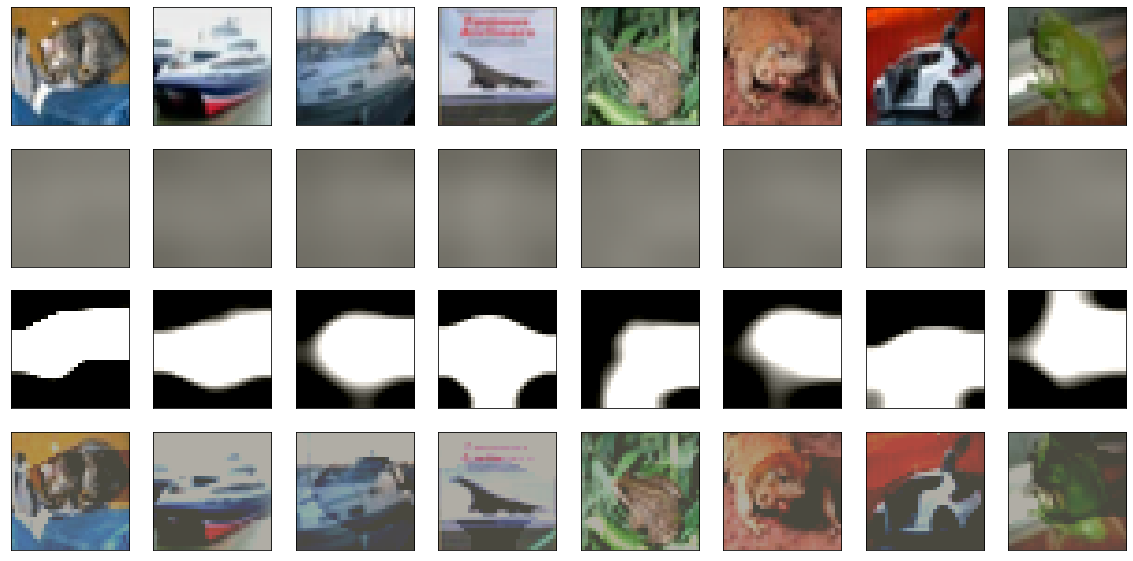

In [100]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=1, attack_epsilon=0.5, attack_step_size=1 )
# grad_cam.model
resized_cam, attention_map, adv, _, pred = grad_cam.generate_add_cam(inputs, targets)
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


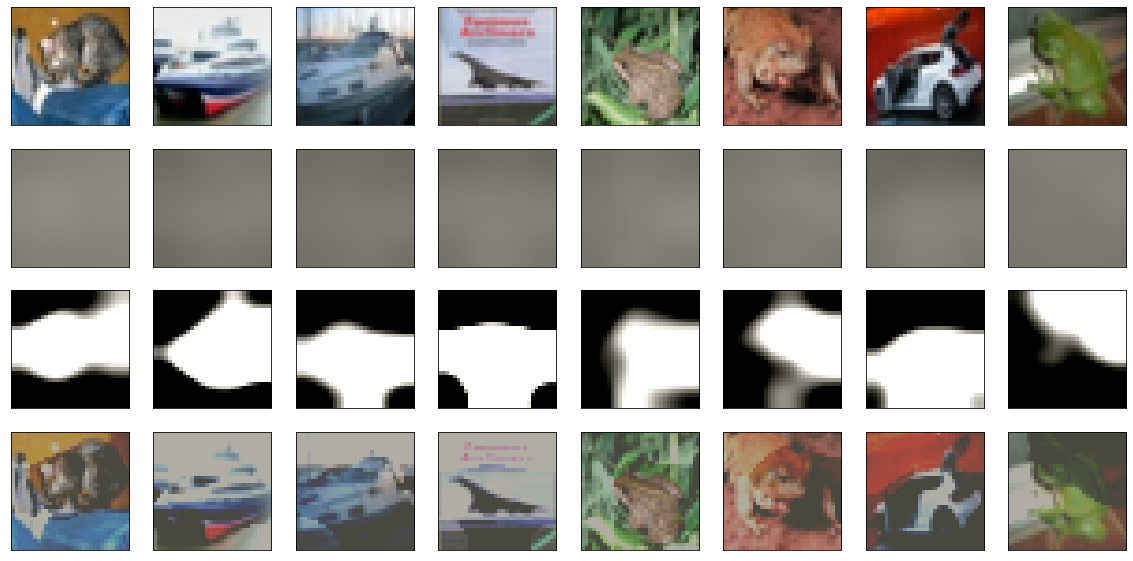

In [95]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=2, attack_epsilon=0.5, attack_step_size=1 )
# grad_cam.model
resized_cam, attention_map, adv, _, pred  = grad_cam.generate_add_cam(inputs, targets)
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu()])

In [96]:
pred

tensor([3, 8, 8, 8, 6, 5, 0, 2], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


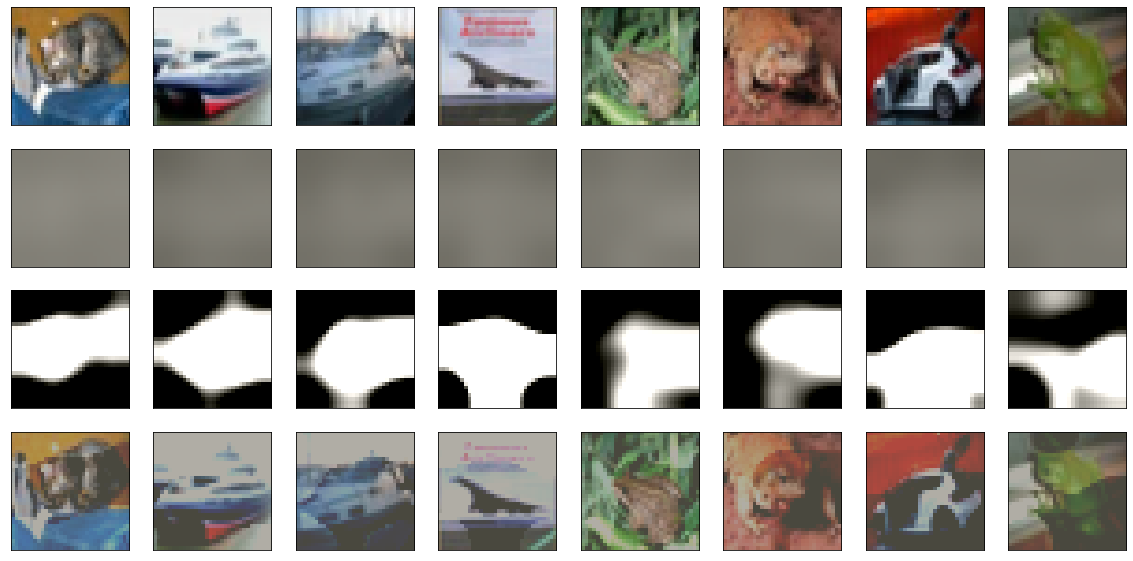

In [97]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=3, attack_epsilon=0.5, attack_step_size=1 )
# grad_cam.model
resized_cam, attention_map, adv, _, pred  = grad_cam.generate_add_cam(inputs, targets)
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu()])

In [101]:
pred

tensor([3, 8, 0, 8, 6, 5, 0, 5], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


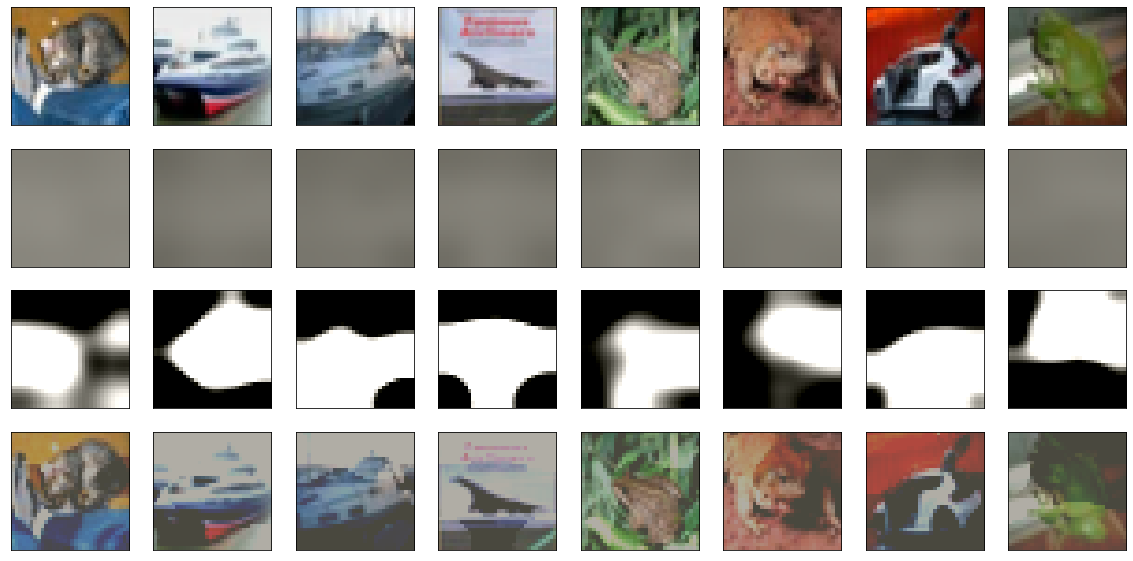

In [103]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=4, attack_epsilon=0.5, attack_step_size=1 )
# grad_cam.model
resized_cam, attention_map, adv, _, pred  = grad_cam.generate_add_cam(inputs, targets)
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu()])

In [105]:
pred

tensor([3, 8, 8, 0, 6, 5, 0, 2], device='cuda:0')

In [24]:
# Hook the selected layer
# for n, m in model.named_modules():
#     print(n)
#     if n == str(target_layer):
#         m.register_forward_hook(forward_hook)
#         m.register_backward_hook(backward_hook)

In [25]:
grad_cam = GradCam(model, target_layer=target_layer)
# grad_cam.model
adv_attention_map, attention_map, resized_cam, model_output, one_hot_output = grad_cam.generate_cam(inputs, targets)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [26]:
attention_image = inputs * attention_map.repeat(1, 3, 1, 1)
adv_attention_image = inputs * adv_attention_map.repeat(1, 3, 1, 1)
# adv_attention_image2 = inputs - attention_map.repeat(1, 3, 1, 1)

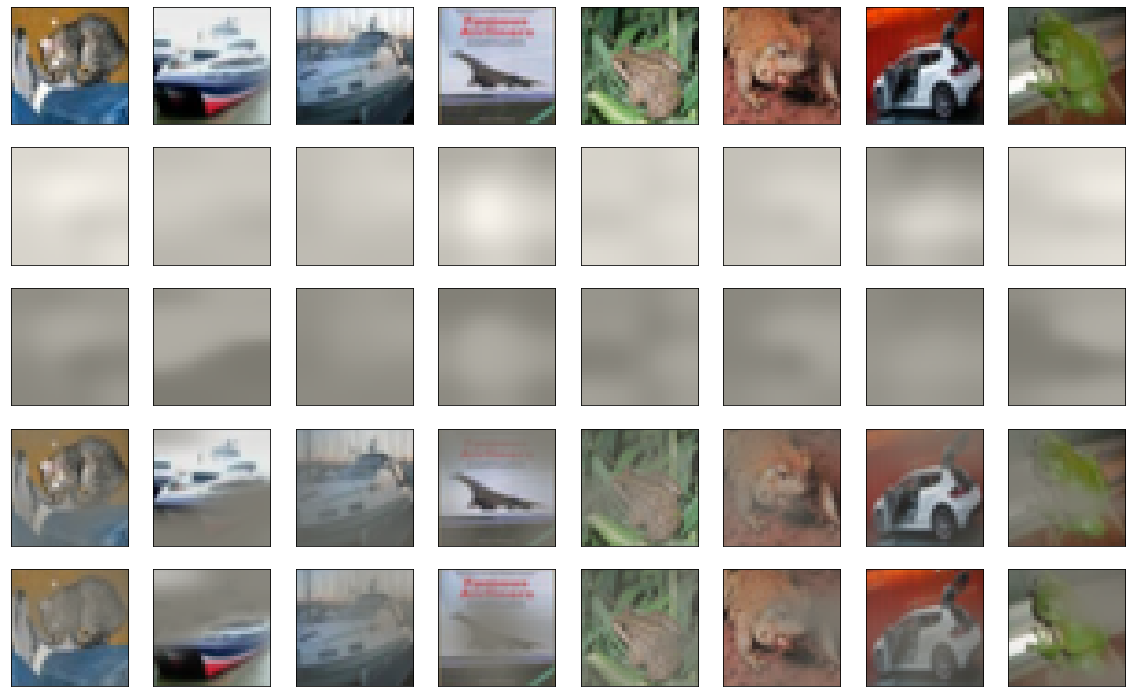

In [27]:
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu(), attention_image.detach().cpu(), adv_attention_image.detach().cpu()])

In [25]:
adv_attention_map2, attention_map2, resized_cam2, model_output2, one_hot_output2 = grad_cam.generate_cam(adv_attention_image, targets)

attention_image2 = adv_attention_image * attention_map2.repeat(1, 3, 1, 1)
adv_attention_image2 = adv_attention_image * adv_attention_map2.repeat(1, 3, 1, 1)

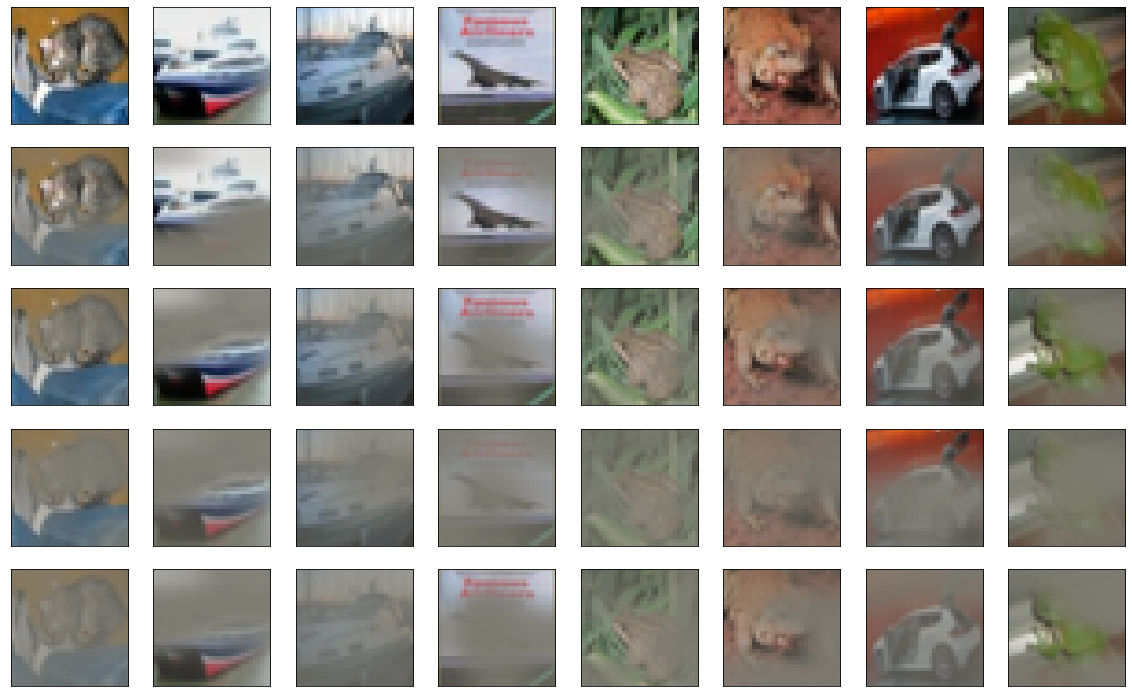

In [26]:
show_image_row([inputs.cpu(), attention_image.detach().cpu(), adv_attention_image.detach().cpu(), attention_image2.detach().cpu(), adv_attention_image2.detach().cpu()])

In [27]:
adv_attention_map_p, attention_map_p, resized_cam_p, model_output_p, one_hot_output_p = grad_cam.generate_cam(inputs, targets)

attention_image_p = F.relu(inputs) + F.relu(attention_map_p.repeat(1, 3, 1, 1)) - (F.relu(-inputs) + F.relu(-attention_map_p.repeat(1, 3, 1, 1)))
adv_attention_image_p = F.relu(inputs) - F.relu(attention_map_p.repeat(1, 3, 1, 1)) - (F.relu(-inputs) - F.relu(-attention_map_p.repeat(1, 3, 1, 1)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

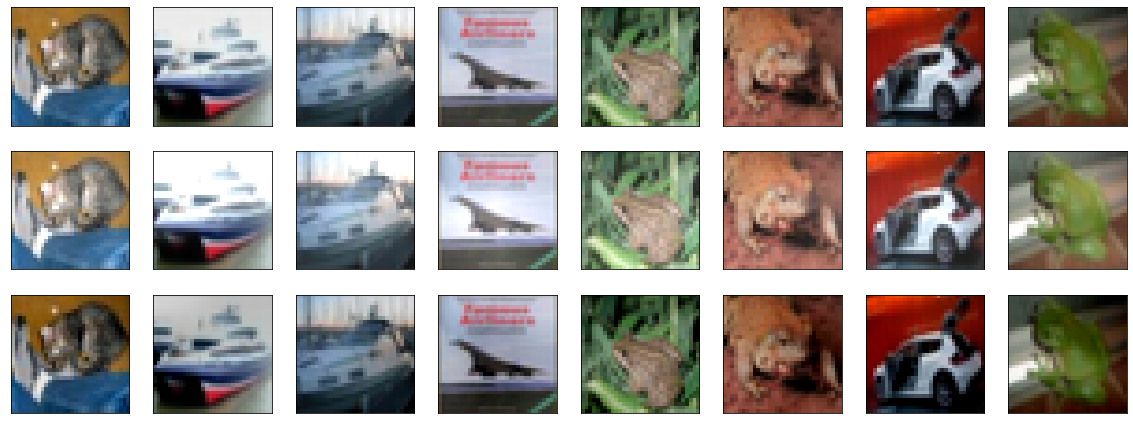

In [28]:
show_image_row([inputs.cpu(), attention_image_p.detach().cpu(), adv_attention_image_p.detach().cpu()])

In [29]:
adv_attention_map_p2, attention_map_p2, resized_cam_p2, model_output_p2, one_hot_output_p2 = grad_cam.generate_cam(adv_attention_image_p, targets)

attention_image_p2 = F.relu(adv_attention_image_p) + F.relu(attention_map_p2.repeat(1, 3, 1, 1)) - (F.relu(-adv_attention_image_p) + F.relu(-attention_map_p2.repeat(1, 3, 1, 1)))
adv_attention_image_p2 = F.relu(adv_attention_image_p) - F.relu(attention_map_p2.repeat(1, 3, 1, 1)) - (F.relu(-adv_attention_image_p) - F.relu(-attention_map_p2.repeat(1, 3, 1, 1)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

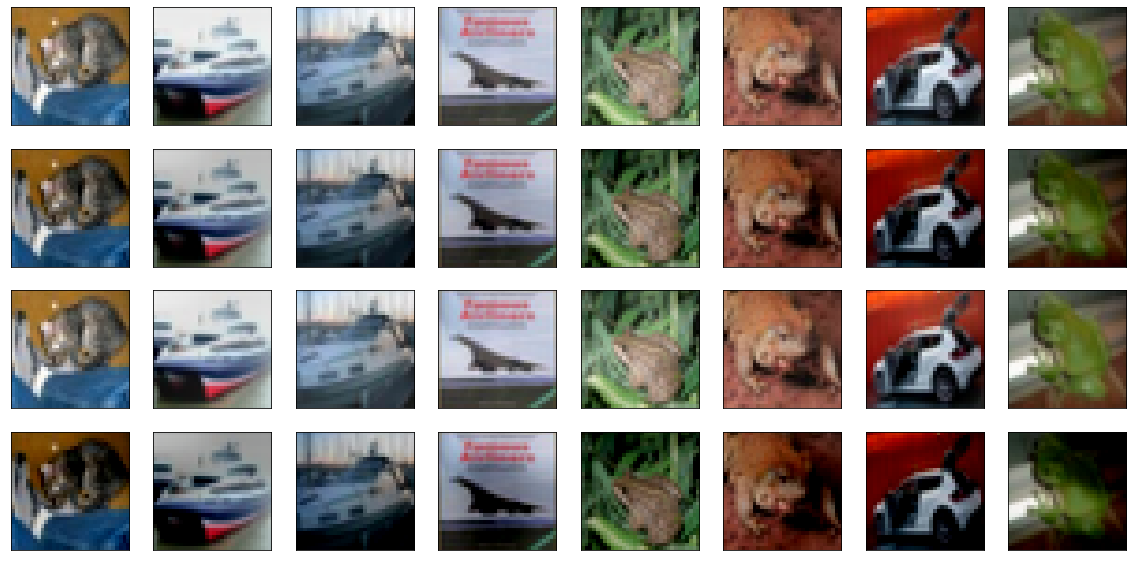

In [71]:
show_image_row([inputs.cpu(), adv_attention_image_p.detach().cpu(), attention_image_p2.detach().cpu(), adv_attention_image_p2.detach().cpu()])

In [59]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer, attack_iter=1, attack_epsilon=1, attack_step_size=1):
        self.model = model
        self.target_layer = target_layer
        self.attack_iter = attack_iter
        self.attack_epsilon = attack_epsilon
        self.attack_step_size = attack_step_size
        self.model.eval()
        self.hook_layer()

    def hook_layer(self):
        def forward_hook(module, input, output):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = output

        def backward_hook(module, grad_in, grad_output):
            self.gradient = torch.squeeze(grad_output[0])

        # Hook the selected layer
        for n, m in self.model.named_modules():
            if n == str(self.target_layer):
                m.register_forward_hook(forward_hook)
                m.register_backward_hook(backward_hook)


    def generate_mul_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        # input image [1, 3, 224, 224]
        # cont_output [1, 256, 13, 13]
        
        adv = input_image
        B, C, H, W = input_image.size()
        lower_bound = torch.clamp(input_image - self.attack_epsilon, min=-1., max=1.)
        upper_bound = torch.clamp(input_image + self.attack_epsilon, min=-1., max=1.)
#         lower_bound = input_image - self.attack_epsilon
#         upper_bound = input_image + self.attack_epsilon
        
        for i in range(self.attack_iter):
        
            model_output, target_class = self.model(adv, target_class)
            if target_class is None:
                target_class = np.argmax(model_output.data.numpy())
            # Target for backprop
            one_hot_output = torch.zeros_like(model_output).cuda()
            one_hot_output = torch.nn.functional.one_hot(targets, num_classes=10)

            # Zero grads
            self.model.zero_grad()
            # Backward pass with specified target
            model_output.backward(gradient=one_hot_output, retain_graph=True)
            # Get hooked gradients
            guided_gradients = self.gradient
            # Get convolution outputs
            target = self.conv_output
            # Get weights from gradients
            weights = guided_gradients.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)# torch.mean(guided_gradients, dim=1, keepdim=True)
            # Create empty numpy array for cam
            cam = (target * weights).sum(dim=1, keepdim=True)

            resized_cam = torch.nn.functional.interpolate(cam, (H, W), mode='bicubic')
            resized_cam = self.standardize(resized_cam)
            resized_cam2 = self.normalize(resized_cam)
            attention_map = F.sigmoid(resized_cam)
            adv_attention_map = F.sigmoid(-resized_cam)

            adv = adv * adv_attention_map.repeat(1, 3, 1, 1)
            
            adv_orig = adv
            
            # Linf project
            adv = torch.where(adv > lower_bound, adv, lower_bound).detach()
            adv = torch.where(adv < upper_bound, adv, upper_bound).detach()

        return resized_cam, resized_cam2, adv, adv_orig, attention_map
    
    def standardize(self, resized_cam):
        resized_cam_mean = resized_cam.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        resized_cam_std = resized_cam.std(dim=2, keepdim=True).std(dim=3, keepdim=True) * self.attack_epsilon
        resized_cam = (resized_cam - resized_cam_mean) / (resized_cam_std+1e-5)
        
        return resized_cam
    
    def normalize(self, resized_cam):
        
        resized_cam = (resized_cam - torch.min(resized_cam)) / (torch.max(resized_cam) - torch.min(resized_cam))
        
        return resized_cam
        
        
        

In [60]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=2, attack_epsilon=0.5, attack_step_size=1)
resized_cam, resized_cam2, adv, adv_orig, attention_map = grad_cam.generate_mul_cam(inputs, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


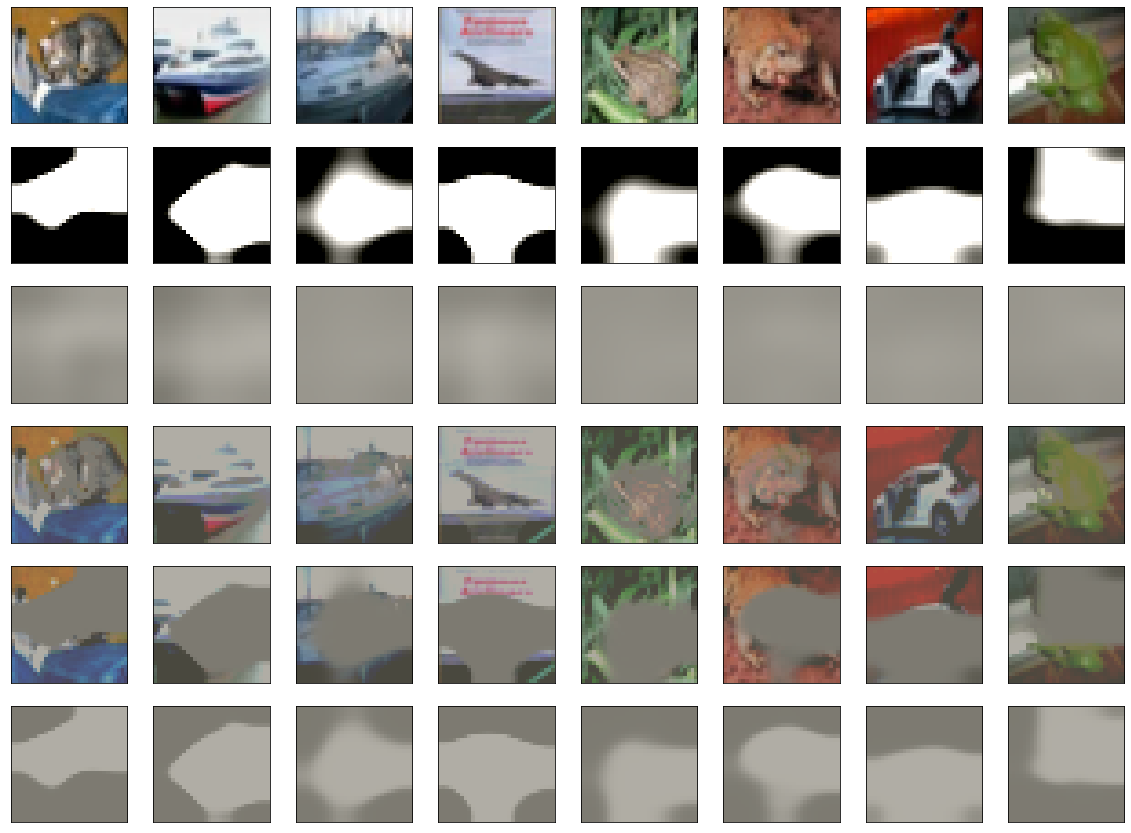

In [61]:
show_image_row([inputs.cpu(), resized_cam.repeat(1, 3, 1, 1).detach().cpu(), resized_cam2.repeat(1, 3, 1, 1).detach().cpu(), adv.detach().cpu(), adv_orig.detach().cpu(), attention_map.repeat(1, 3, 1, 1).detach().cpu()])

In [62]:
torch.mean(adv)

tensor(-0.0907, device='cuda:0')

In [63]:
torch.mean(inputs)

tensor(-0.1155, device='cuda:0')

In [64]:
torch.std(adv)

tensor(0.7004, device='cuda:0')

In [65]:
torch.std(inputs)

tensor(1.2284, device='cuda:0')

In [66]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer, attack_iter=1, attack_epsilon=1, attack_step_size=1):
        self.model = model
        self.target_layer = target_layer
        self.attack_iter = attack_iter
        self.attack_epsilon = attack_epsilon
        self.attack_step_size = attack_step_size
        self.model.eval()
        self.hook_layer()

    def hook_layer(self):
        def forward_hook(module, input, output):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = output

        def backward_hook(module, grad_in, grad_output):
            self.gradient = torch.squeeze(grad_output[0])

        # Hook the selected layer
        for n, m in self.model.named_modules():
            if n == str(self.target_layer):
                m.register_forward_hook(forward_hook)
                m.register_backward_hook(backward_hook)


    def generate_mul_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        # input image [1, 3, 224, 224]
        # cont_output [1, 256, 13, 13]
        
        adv = input_image
        B, C, H, W = input_image.size()
        lower_bound = torch.clamp(input_image - self.attack_epsilon, min=-1., max=1.)
        upper_bound = torch.clamp(input_image + self.attack_epsilon, min=-1., max=1.)
#         lower_bound = input_image - self.attack_epsilon
#         upper_bound = input_image + self.attack_epsilon
        
        for i in range(self.attack_iter):
        
            model_output, target_class = self.model(adv, target_class)
            if target_class is None:
                target_class = np.argmax(model_output.data.numpy())
            # Target for backprop
            one_hot_output = torch.zeros_like(model_output).cuda()
            one_hot_output = torch.nn.functional.one_hot(targets, num_classes=10)

            # Zero grads
            self.model.zero_grad()
            # Backward pass with specified target
            model_output.backward(gradient=one_hot_output, retain_graph=True)
            # Get hooked gradients
            guided_gradients = self.gradient
            # Get convolution outputs
            target = self.conv_output
            # Get weights from gradients
            weights = guided_gradients.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)# torch.mean(guided_gradients, dim=1, keepdim=True)
            # Create empty numpy array for cam
            cam = (target * weights).sum(dim=1, keepdim=True)
#             cam_mean = cam.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
#             cam_std = cam.std(dim=2, keepdim=True).std(dim=3, keepdim=True) * attack_epsilon
#             cam = (cam - cam_mean) / (torch.max(cam) - torch.min(cam) + 1e-5)

            resized_cam = torch.nn.functional.interpolate(cam, (H, W), mode='bicubic')
            attention_map_p= self.standardize(resized_cam)
            attention_map_p2 = self.normalize(resized_cam)
            
            adv = F.relu(adv) - F.relu(attention_map_p.repeat(1, 3, 1, 1)) - (F.relu(-adv) - F.relu(-attention_map_p.repeat(1, 3, 1, 1)))
#             adv2 = F.relu(adv) - F.relu(attention_map_p2.repeat(1, 3, 1, 1)) - (F.relu(-adv) - F.relu(-attention_map_p2.repeat(1, 3, 1, 1)))
      
            adv_orig = adv
            
            
            # Linf project
            adv = torch.where(adv > lower_bound, adv, lower_bound).detach()
            adv = torch.where(adv < upper_bound, adv, upper_bound).detach()
            
        return adv, adv_orig, attention_map_p
    
    def standardize(self, resized_cam):
        resized_cam_mean = resized_cam.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        resized_cam_std = resized_cam.std(dim=2, keepdim=True).std(dim=3, keepdim=True) * self.attack_epsilon
        resized_cam = (resized_cam - resized_cam_mean) / (resized_cam_std+1e-5)
        
        return resized_cam
    
    def normalize(self, resized_cam):
        
        resized_cam = (resized_cam - torch.min(resized_cam)) / (torch.max(resized_cam) - torch.min(resized_cam))
        
        return resized_cam
        
        
        

In [69]:
grad_cam = GradCam(model, target_layer=target_layer, attack_iter=1, attack_epsilon=0.5, attack_step_size=1)
adv, adv_orig, attention_map = grad_cam.generate_mul_cam(inputs, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


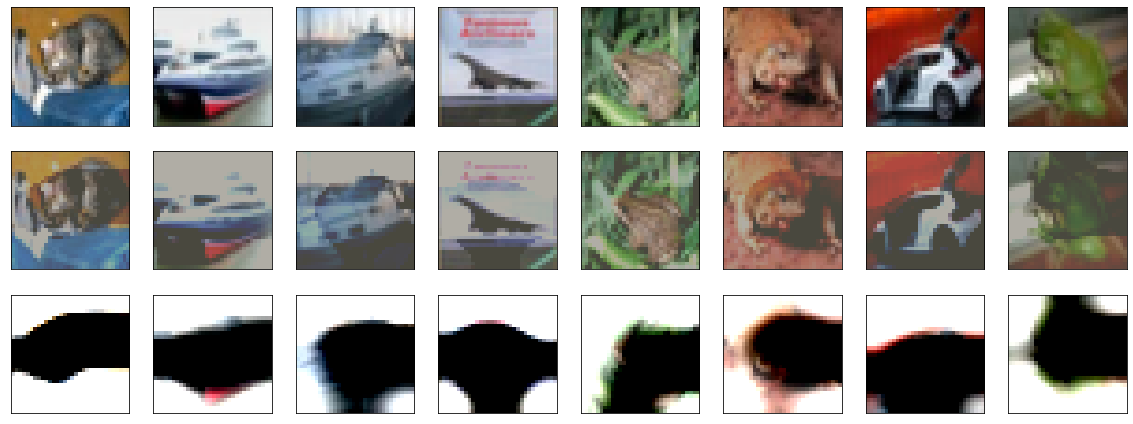

In [70]:
show_image_row([inputs.cpu(), adv.detach().cpu(), adv_orig.detach().cpu()])

In [55]:
torch.mean(adv)

tensor(-0.1146, device='cuda:0')

In [56]:
torch.mean(inputs)

tensor(-0.1155, device='cuda:0')

In [57]:
torch.std(adv)

tensor(0.8007, device='cuda:0')

In [58]:
torch.std(inputs)

tensor(1.2284, device='cuda:0')

In [80]:
class NoOpAttacker():
    
    def attack(self, image, label, model):
        return image, -torch.ones_like(label)

    def set_model(self, model):
        self.model = model


class PGDAttacker():
    def __init__(self, num_iter, epsilon, step_size, kernel_size=15, prob_start_from_clean=0.0, translation=False, num_classes=1000, device='cuda:0',
                 dct_ratio_low=0.0, dct_ratio_high=1.0):
        step_size = max(step_size, epsilon / num_iter)
        self.num_iter = num_iter
        self.epsilon = epsilon * IMAGE_SCALE
        self.step_size = step_size*IMAGE_SCALE
        self.prob_start_from_clean = prob_start_from_clean
        self.device = device
        self.translation = translation
        self.num_classes = num_classes
        self.dct_ratio_low = dct_ratio_low
        self.dct_ratio_high = dct_ratio_high
        # self.dg = SMNorm(3, 3, groups=3)
        # self.gblur = CustomBlurPool(3, 3, 5, )

        if translation:
            # this is equivalent to deepth wise convolution
            # details can be found in the docs of Conv2d.
            # "When groups == in_channels and out_channels == K * in_channels, where K is a positive integer, this operation is also termed in literature as depthwise convolution."
            self.conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=kernel_size, stride=(kernel_size-1)//2, bias=False, groups=3).to(self.device)
            self.gkernel = get_kernel(kernel_size, nsig=3, device=self.device).to(self.device)
            self.conv.weight = self.gkernel

    def _create_random_target(self, label):
        label_offset = torch.randint_like(label, low=0, high=self.num_classes)
        return (label + label_offset) % self.num_classes

    def attack(self, image_clean, label, model, original=False, mode='pgd'):
        if mode == 'pgd':
            return self.pgd_attack(image_clean, label, model.module._forward_impl, original=False)
        elif mode == "pgd_dct":
            return self.pgd_dct_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "attention":
            return self.attention_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "gradcam_attention":
            return self.gradcam_attention_attack(image_clean, label, model, original=False)
        elif mode == "dg":
            return self.dg_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "gblur":
            return self.gblur_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "common":
            return self.common_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "advbn":
            return self.advbn_attack(image_clean, label, model._forward_impl, original=False)
        elif mode == "gnoise":
            return self.gaussian_noise_attack(image_clean, label, mean=0.0, std=0.5)
        elif mode == "unoise":
            return self.uniform_noise_attack(image_clean, label)
        elif mode == "dummy" or "sm" or "sm-lf":
            return self.dummy_attack(image_clean, label)

    def set_model(self, model):
        self.model = model

    def pgd_attack(self, image_clean, label, model, original=False):
        """
        aux_images, _ = self.attacker.attack(x, labels, self._forward_impl)
        """
        if original:
            target_label = label    # untargeted
        else:
            target_label = self._create_random_target(label)    # targeted
        lower_bound = torch.clamp(image_clean - self.epsilon, min=-1., max=1.)
        upper_bound = torch.clamp(image_clean + self.epsilon, min=-1., max=1.)

        ori_images = image_clean.clone().detach()

        init_start = torch.empty_like(image_clean).uniform_(-self.epsilon, self.epsilon)
        
        start_from_noise_index = (torch.randn([])>self.prob_start_from_clean).float() 
        start_adv = image_clean + start_from_noise_index * init_start

        adv = start_adv
        for i in range(self.num_iter):
            adv.requires_grad = True
            logits = model(adv)
            losses = F.cross_entropy(logits, target_label)
            g = torch.autograd.grad(losses, adv, 
                                    retain_graph=False, create_graph=False)[0]
            if self.translation:
                g = self.conv(g)
            # Linf step
            if original:
                adv = adv + torch.sign(g) * self.step_size  # untargeted
            else:
                adv = adv - torch.sign(g) * self.step_size  # targeted
            # Linf project
            adv = torch.where(adv > lower_bound, adv, lower_bound).detach()
            adv = torch.where(adv < upper_bound, adv, upper_bound).detach()
        
        return adv, target_label


In [88]:
num_iter = 5
epsilon = 1
step_size = 1


In [89]:
attacker = PGDAttacker(num_iter, epsilon, step_size, kernel_size=15, prob_start_from_clean=0.0, translation=False, num_classes=10, device='cuda:0',
                 dct_ratio_low=0.0, dct_ratio_high=1.0)
adv, target = attacker.attack(inputs, targets, model, mode='pgd')

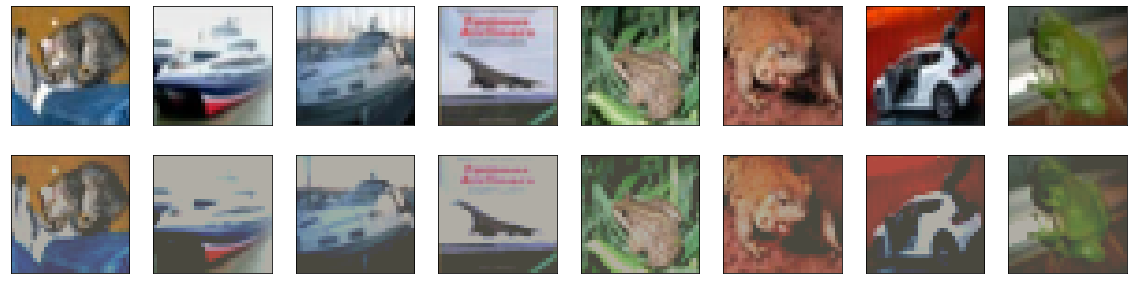

In [90]:
show_image_row([inputs.cpu(), adv.detach().cpu()])

In [ ]:
grad_cam = GradCam(model, target_layer=target_layer)
# grad_cam.model
adv_attention_map, attention_map, resized_cam, model_output, one_hot_output = grad_cam.generate_cam(inputs, targets)

In [ ]:
grad_cam = GradCam(model, target_layer=target_layer)
# grad_cam.model
adv_attention_map, attention_map, resized_cam, model_output, one_hot_output = grad_cam.generate_cam(adv, targets)

In [ ]:
show_image_row([inputs.cpu(), adv.detach().cpu(), ])

In [91]:
torch.mean(inputs)

tensor(-0.1155, device='cuda:0')

In [92]:
torch.std(inputs)

tensor(1.2284, device='cuda:0')

In [93]:
torch.mean(adv)

tensor(-0.1191, device='cuda:0')

In [94]:
torch.std(adv)

tensor(0.7995, device='cuda:0')

In [25]:
one_hot = torch.nn.functional.one_hot(targets, num_classes=10)

In [26]:
one_hot

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], device='cuda:0')

In [ ]:
one_hot_output

In [ ]:
targets.size()

In [144]:
one_hot = torch.nn.functional.one_hot(targets)

RuntimeError: CUDA error: device-side assert triggered

In [143]:
one_hot_output

RuntimeError: CUDA error: device-side assert triggered

In [101]:
outputs.size()

torch.Size([8, 10])

In [102]:
outputs

tensor([[ 0.1867,  0.4894,  0.1309, -0.0861,  0.2748,  0.4078, -0.3992, -0.7963,
          0.4108, -0.3264],
        [ 0.3571,  0.4329, -0.1622, -0.3312,  0.4945,  0.2245, -0.1775, -1.0768,
          0.3620,  0.4899],
        [ 0.0571,  0.0964,  0.3360,  0.0099,  0.3230,  0.0440, -0.2828, -0.9215,
          0.2547, -0.2514],
        [ 0.2930,  0.4237, -0.1541, -0.0065,  0.0040, -0.0027, -0.2112, -0.8137,
          0.2469, -0.0948],
        [ 0.2251,  0.3674,  0.3376, -0.1454,  0.2021,  0.1186, -0.1280, -0.7280,
          0.3136, -0.0124],
        [ 0.2050,  0.4288,  0.2098, -0.2271,  0.2893,  0.1821, -0.1279, -0.7357,
          0.8228, -0.0182],
        [ 0.8938, -0.1048, -0.3382, -0.6507,  0.4771, -0.0097, -0.6056, -1.7278,
          0.8416,  0.6434],
        [-0.1400,  0.4883,  0.4273, -0.1215,  0.0893,  0.1717, -0.3951, -0.7608,
          0.2233, -0.0322]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
show_image_row()